## Modeling Inspection of the Food Establishments in the City of Chicago

## Project Plan
 - Project Goal
 - Dataset and features
 - Exploratory data analysis (EDA) 
 - Patterns, insights, pecularities of data
 - Data preprocessing
 - Feature engineering and description
 - Cross-validation, hyperparameter tuning
 - Validation and learning curves
 - Prediction for hold-out and test samples
 - Model evaluation with metrics description
 - Conclusions


### Project Goal
The goal of this project is to model the vilolations/failures by the food establishments in the city of chicago. 

### Data Set and Features  
We used city of Chicago's Socrata Open Data (SODA) API to acess food inspection data for 2018 and 2019. In addition to the food inspection data, we are using burglary/crime, 311 sanitation complaints, businesss license data as well.

## Exploratory Data Analysis 

In [1]:
#important libraries
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import json
sns.set(rc={'figure.figsize':(12, 6),"font.size":20,"axes.titlesize":20,"axes.labelsize":20},style="darkgrid")
import matplotlib.dates as mdates
import re
from datetime import datetime, timedelta
import time
from datetime import datetime, date, time, timedelta


In [2]:
food_data = pd.read_json('../data/raw/food-inspection.json', convert_dates = ['inspection_date'])

In [3]:
food_data.head(2)

,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license_,location,longitude,results,risk,state,violations,zip
0,6136 S PULASKI RD,BELLA LUNA BAR,CHICAGO,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443.0,"{'type': 'Point', 'coordinates': [-87.72297770...",-87.722978,Pass,Risk 3 (Low),IL,None,60629.0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,CHICAGO,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559.0,"{'type': 'Point', 'coordinates': [-87.62393736...",-87.623937,Not Ready,Risk 1 (High),IL,None,60616.0


In [4]:
food_data.rename(columns={'license_':'license'}, inplace=True)

In [5]:
shape = food_data.shape
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))

 So there are 44760 rows and 17 columns in the data


In [6]:
food_data.isna().sum()

address                0
aka_name             190
city                  48
dba_name               0
facility_type        277
inspection_date        0
inspection_id          0
inspection_type        0
latitude             178
license                2
location             178
longitude            178
results                0
risk                  17
state                 27
violations         11141
zip                    9
dtype: int64

Let us do some data clean up:

In [7]:
food_data = food_data[np.isfinite(food_data['license'])]
food_data = food_data[ (food_data['license'] > 0) & (food_data['inspection_date'] != 0) ]
food_data = food_data.drop(['location', 'zip', 'state', 'city'], axis=1)
food_data['latitude'].fillna(food_data['latitude'].mode()[0], inplace=True)
food_data['longitude'].fillna(food_data['longitude'].mode()[0], inplace=True)
food_data['aka_name'].fillna(food_data['dba_name'], inplace=True)
food_data['license'] = food_data['license'].astype('int')

In [8]:
food_data.isna().sum()

address                0
aka_name               0
dba_name               0
facility_type        274
inspection_date        0
inspection_id          0
inspection_type        0
latitude               0
license                0
longitude              0
results                0
risk                  16
violations         11122
dtype: int64

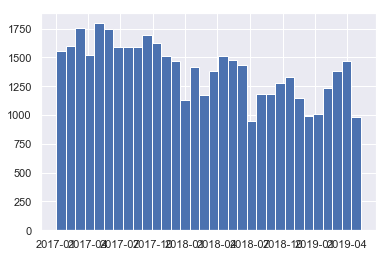

In [9]:
#food_data.unstack.plot(['inspection_date'].hist(bins=16, use_index=True)
food_data['inspection_date'].hist(bins = 32)

In [10]:
#what's in the data? 
food_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44687 entries, 0 to 9999
Data columns (total 13 columns):
address            44687 non-null object
aka_name           44687 non-null object
dba_name           44687 non-null object
facility_type      44413 non-null object
inspection_date    44687 non-null datetime64[ns]
inspection_id      44687 non-null int64
inspection_type    44687 non-null object
latitude           44687 non-null float64
license            44687 non-null int64
longitude          44687 non-null float64
results            44687 non-null object
risk               44671 non-null object
violations         33565 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(8)
memory usage: 4.8+ MB


In [11]:
#simple statistics 
food_data.describe()
#food_data.set_index('inspection_date')

,inspection_id,latitude,license,longitude
count,4.468700e+04,44687.000000,4.468700e+04,44687.000000
mean,2.129673e+06,41.885972,1.849083e+06,-87.678130
std,9.749960e+04,0.080434,8.963441e+05,0.060751
min,2.638040e+05,41.644670,2.000000e+00,-87.914428
25%,2.064474e+06,41.847292,1.594476e+06,-87.707842
50%,2.135501e+06,41.893889,2.215928e+06,-87.666342
75%,2.213734e+06,41.943775,2.475923e+06,-87.636298
max,2.288551e+06,42.021064,3.808890e+06,-87.525094


In [12]:
def count_critical_violations(violations):
    non_critical_violations_count = 0
    critical_violations_count = 0
    minor_violations_count = 0
    try:
        x = violations.split('|')
        codes = []
        for violation in x:
            match = int(re.search(r'\d+', violation).group(0))
            codes.append(match)
        for code in codes:
            if code > 0 and code < 15:
                minor_violations_count += 1
            elif code > 15 and code < 30:
                non_critical_violations_count += 1
            else:
                critical_violations_count += 1
        return [minor_violations_count, non_critical_violations_count, critical_violations_count]
        #return(critical_violations_count)
    except:
        return [0]    

In [13]:
food_data['violations_list'] = food_data['violations'].apply(lambda x: count_critical_violations(x))
food_data['minor_violations'] = food_data['violations_list'].apply(lambda x : x[0])
food_data['non_critical_violations'] = food_data['violations_list'].apply(lambda x : x[1] if len(x) > 1 else 0)
food_data['critical_violations'] = food_data['violations_list'].apply(lambda x : x[2] if len(x) > 1 else 0)

In [14]:
food_data.head(2)

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,violations,violations_list,minor_violations,non_critical_violations,critical_violations
0,6136 S PULASKI RD,BELLA LUNA BAR,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443,-87.722978,Pass,Risk 3 (Low),None,[0],0,0,0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559,-87.623937,Not Ready,Risk 1 (High),None,[0],0,0,0


#### Let's drop some redudant and unnecessary columns from the dataframe and also clean up column_names.

In [15]:
food_data = food_data.drop(['violations_list', 'violations'], axis=1)

In [16]:
food_data.head(2)

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations
0,6136 S PULASKI RD,BELLA LUNA BAR,BELLA LUNA BAR,BANQUET HALL,2017-01-03,1978834,License Re-Inspection,41.781158,2476443,-87.722978,Pass,Risk 3 (Low),0,0,0
1,2216 S MICHIGAN AVE,JAMAICA JERK VILLA,JAMAICA JERK VILLA,Restaurant,2017-01-03,1978825,License,41.852341,2464559,-87.623937,Not Ready,Risk 1 (High),0,0,0


In [17]:
food_data.isna().sum()

address                      0
aka_name                     0
dba_name                     0
facility_type              274
inspection_date              0
inspection_id                0
inspection_type              0
latitude                     0
license                      0
longitude                    0
results                      0
risk                        16
minor_violations             0
non_critical_violations      0
critical_violations          0
dtype: int64

#### Let's see the frequency of these inspections. 

Text(0.5, 0, 'Inspection Date')

Text(0, 0.5, 'Number of Inspections')

Text(0.5, 1.0, 'Daily Inspections')

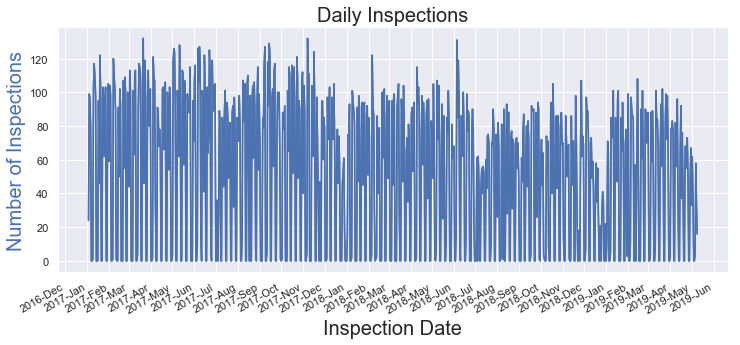

In [18]:
per_day = pd.DataFrame()
per_day =  food_data[['inspection_date', 'inspection_id']]
per_day = per_day.set_index(pd.to_datetime(per_day['inspection_date']))
per_day = per_day.resample('D').count()
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(per_day.index, per_day, 'b-')
plt.xlabel('Inspection Date')
plt.ylabel('Number of Inspections', color='b')
plt.title('Daily Inspections')
plt.show()

In [19]:
print("%s unique facilites were inspected during the period" %food_data['license'].nunique())

16275 unique facilites were inspected during the period


### Let's look at the results of these inspection more closely: 
A facility can either pass, pass with conditions or fail. Following is an excerpt from the dataset documentation page:

"Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15-29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such".

In [20]:
food_data['results'].value_counts()

Pass                    19919
Pass w/ Conditions      10023
Fail                     8506
Out of Business          3064
No Entry                 2122
Not Ready                1045
Business Not Located        8
Name: results, dtype: int64

Text(0.5, 1.0, 'Result of Inspections')

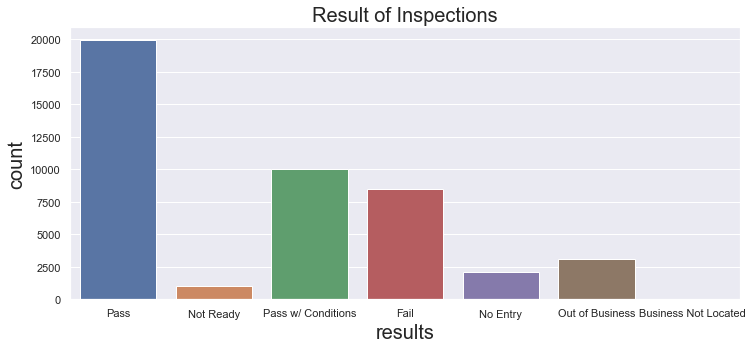

In [21]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

### Let's convert results in to categorical variable first and the we will filter out non-relevant categories like 'Out of Business', 'Not Ready' and 'No Entry' facilities. 

In [22]:
results_conv = {"results" : {"Fail" : 0, "Pass" : 1, "Pass w/ Conditions" : 1, "Out of Business": 2, "No Entry": 3 , "Not Ready": 4, 'Business Not Located' : 5}}
food_data.replace(results_conv, inplace=True)
print(food_data.results.dtype)

int64


In [23]:
food_data = food_data[food_data['results'] < 2]

Text(0.5, 1.0, 'Result of Inspections')

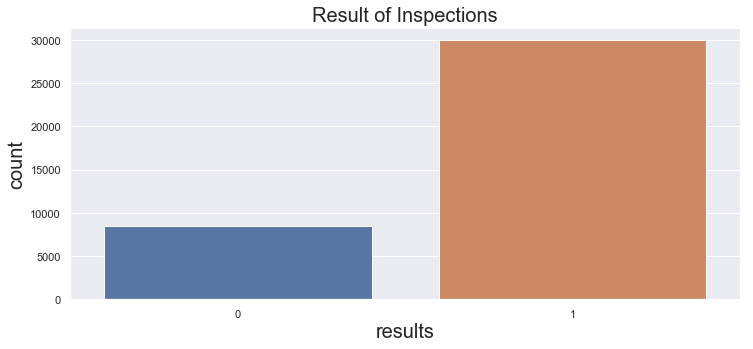

In [24]:
ax = sns.countplot(x="results", data=food_data)
plt.title("Result of Inspections")
plt.show()

Text(0.5, 1.0, 'Distribution of Critical Violations')

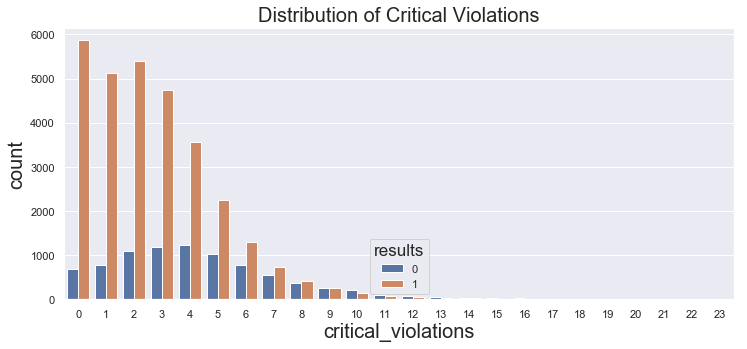

In [25]:
ax = sns.countplot(x="critical_violations", hue = 'results', data=food_data)
plt.title("Distribution of Critical Violations")
plt.show()

This clearly shows more the number of critical violations, more the failure rate.  

Text(0.5, 1.0, 'Distribution of Non Critical Violations')

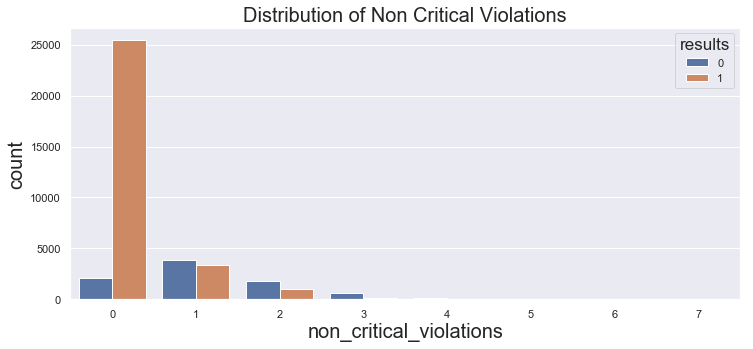

In [26]:
# how about non_critical_violations ? 
ax = sns.countplot(x="non_critical_violations", hue = 'results', data=food_data)
plt.title("Distribution of Non Critical Violations")
plt.show()

Text(0.5, 1.0, 'Distribution of Non Critical Violations')

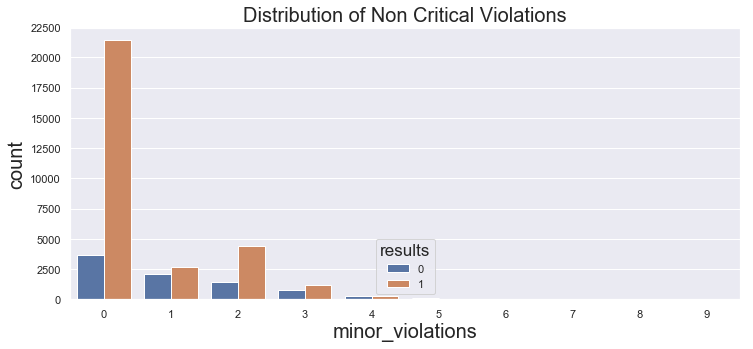

In [27]:
# how about non_critical_violations ? 
ax = sns.countplot(x="minor_violations", hue = 'results', data=food_data)
plt.title("Distribution of Non Critical Violations")
plt.show()

###  Inspection type: 
According to the dataset description, an inspection can be of the following types:

1) Canvass : The most common type of inspection performed at a frequency relative to the risk of the establishment

2) Consultation: when the inspection is done at the request of the owner prior to the opening of the establishment

3) Complaint: when the inspection is done in response to a complaint against the establishment

4) license : when the inspection is done as a requirement for the establishment to receive its license to operate

5) suspect food poisoning : when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaint based inspection)

6) Task-force inspection: when an inspection of a bar or tavern is done.

7) Re-inspections:  Occurs for most types of these inspections and are indicated as such.pe



In [28]:
food_data['inspection_type'].value_counts()

Canvass                                   18688
License                                    5272
Canvass Re-Inspection                      5171
Complaint                                  4378
Complaint Re-Inspection                    1834
License Re-Inspection                      1808
Short Form Complaint                        997
Suspected Food Poisoning                    153
Recent Inspection                           103
Suspected Food Poisoning Re-inspection       28
Consultation                                 11
Non-Inspection                                4
Recent inspection                             1
Name: inspection_type, dtype: int64

#### A picture speaks thousands numbers, right ? Let's look at these numbers as count plots. 

<Figure size 720x432 with 0 Axes>

Text(0.5, 1.0, 'Result of Inspections')

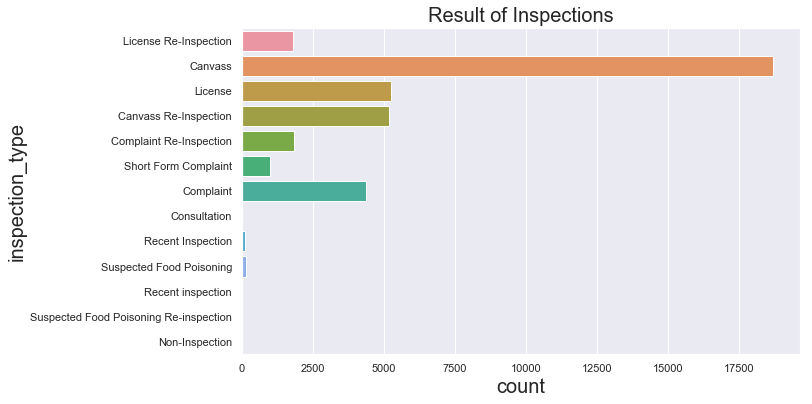

In [29]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(y="inspection_type", data=food_data)
plt.title("Result of Inspections")
plt.show()

#### Since our goal is here to model the failure in random canvas, we are going to focus on canvass inspections only. 

In [30]:
food_data = food_data[food_data['inspection_type'] == 'Canvass']

In [31]:
#food_data = food_data[(food_data['results']== 1) | (food_data['results']== 2) ]

In [32]:
print("%d different types of food establishment facilities were inspected during the period and %d different types of inpsections were conducted during the period."% 
(food_data['facility_type'].nunique(), food_data['inspection_type'].nunique()))

144 different types of food establishment facilities were inspected during the period and 1 different types of inpsections were conducted during the period.


In [33]:
plt.figure(figsize=(13, 13))
food_data['facility_type'].value_counts()[0:10]

<Figure size 936x936 with 0 Axes>

Restaurant                         13071
School                              2238
Grocery Store                       1241
Children's Services Facility         396
Bakery                               261
Long Term Care                       247
Daycare Above and Under 2 Years      230
Daycare (2 - 6 Years)                199
Catering                             126
Hospital                             100
Name: facility_type, dtype: int64

<Figure size 936x936 with 0 Axes>

Text(0.5, 1.0, 'Types of Facilities Inspected')

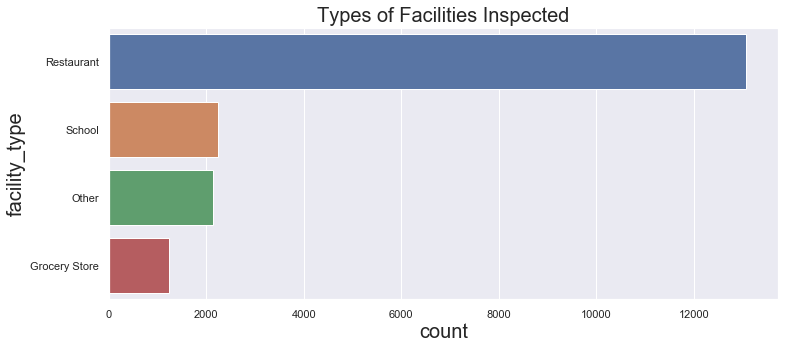

In [34]:
# Setting anything other than Restaurants, Grocery store and School to other types
ftype = lambda x: "Other" if x not in ['Restaurant', 'Grocery Store', 'School'] else x
food_data['facility_type'] = food_data['facility_type'].map(ftype)
ax = sns.countplot(y="facility_type", data=food_data)
plt.title("Types of Facilities Inspected")
plt.show()

In [35]:
food_data = food_data[food_data['facility_type'] == 'Restaurant']

In [36]:
#food_data = food_data.set_index(['inspection_date'])
#food_data = food_data.sort_values(by=['inspection_date'], ascending=False)
#food_data['time_since_last_inspection'] = food_data.groupby(['license'])['inspection_date'].shift(-1)
#food_data[food_data['license'] == 28176]

### Risk categories: 
    
Each establishment is categorized as to its risk of adversely affecting the public’s health:

 1: High

 2: Medium 

 3: Low 

The frequency of inspection is tied to this risk, with risk 1 establishments inspected most frequently and risk 3 least frequently.

In [37]:
food_data['risk'].value_counts()[0:10]

Risk 1 (High)      11572
Risk 2 (Medium)     1474
Risk 3 (Low)          25
Name: risk, dtype: int64

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Risk')

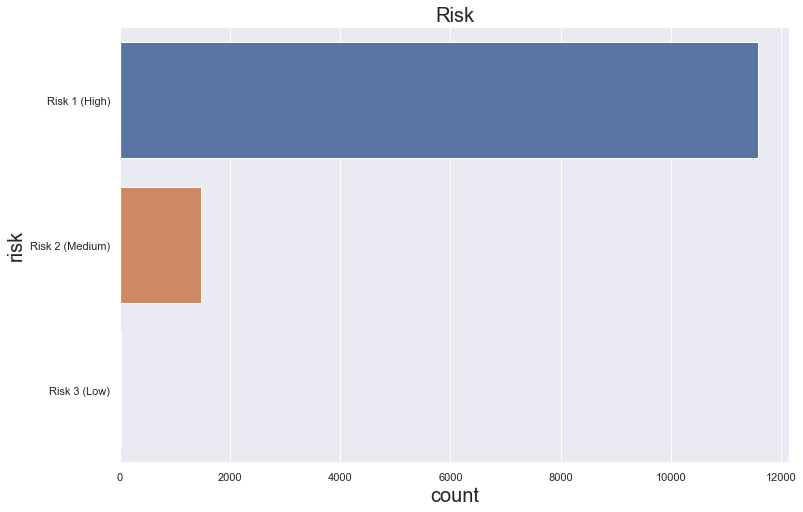

In [38]:
plt.figure(figsize=(12, 8))
ax = sns.countplot(y="risk", data=food_data)
plt.title("Risk")
plt.show()

## Label Encoding categorical variables:

There are couple different ways of label encoding categorical variables.

1) First method is to replace those variables with a dictionary involving key and value pairs of the variables to be encoded. 

2) Another method is to change their type as categorical variable. Let's convert inspection_type for example as as categorical variable. 

In [39]:
#food_data["inspection_type"] = food_data["inspection_type"].astype('category')
food_data["facility_type"] = food_data["facility_type"].astype('category')
food_data["risk"] = food_data["risk"].astype('category')
#food_data["inspection_type_cat"] = food_data["inspection_type"].cat.codes
food_data["facility_type_cat"] = food_data["facility_type"].cat.codes
food_data["risk_type_cat"] = food_data["risk"].cat.codes

In [40]:
food_data.isna().sum()

address                    0
aka_name                   0
dba_name                   0
facility_type              0
inspection_date            0
inspection_id              0
inspection_type            0
latitude                   0
license                    0
longitude                  0
results                    0
risk                       0
minor_violations           0
non_critical_violations    0
critical_violations        0
facility_type_cat          0
risk_type_cat              0
dtype: int64

#### I want to see look these establishments in the map. For plotting, let's divide them into pass and fail data frames.

In [41]:
pass_inspection = food_data[(food_data['results']== 1)]
fail_inspection = food_data[food_data['results']== 0]

### Let's utilize plotly and mapbox to display these restaurants in a map:

In [42]:
import plotly.plotly as py
import plotly.graph_objs as go
import plotly
plotly.tools.set_credentials_file(username='dipakrimal', api_key='0d7jgOoPDZTZV2J0l5u4')
mapbox_access_token = "pk.eyJ1IjoiZGlwYWtyaW1hbCIsImEiOiJjanR0NHp5Z3gxOGVtNGVsbHIxOGI3ZmV6In0.bmrI81LR7L441sUKqDeKmw"

data_pass = [
    go.Scattermapbox(
        lat=pass_inspection['latitude'],
        lon=pass_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(50, 200, 55)',
            opacity=0.7
        ),
        text = pass_inspection['dba_name']  + ' <br> Pass ',
        hoverinfo='text'
    ),
    go.Scattermapbox(
        lat=fail_inspection['latitude'],
        lon=fail_inspection['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12, 
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
         text = fail_inspection['dba_name'] + ' <br> Fail ',
         hoverinfo='text'
    )   
]

layout = go.Layout(
    title = "Chicago Food Insepections",
    width=600,
    height=800,
    showlegend=False,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=41.9,
            lon=-87.7
        ),
        pitch=10,
        zoom=9,
        style='outdoors'
    ),
)

fig = go.Figure(data=data_pass, layout=layout)

py.iplot(fig, filename='Chicago')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~dipakrimal/0 or inside your plot.ly account where it is named 'Chicago'


/anaconda3/lib/python3.7/site-packages/IPython/core/display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [43]:
print(food_data.shape)

(13071, 17)


In [44]:
food_data.head(5)

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations,facility_type_cat,risk_type_cat
10,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2017-01-03,1978836,Canvass,41.943325,2293828,-87.678514,1,Risk 1 (High),1,0,2,0,0
100,619 N WABASH AVE,PIZZERIA DUE,PIZZERIA DUE,Restaurant,2017-01-04,1978927,Canvass,41.893185,1331225,-87.626610,1,Risk 1 (High),0,0,2,0,0
10005,6059 N LINCOLN AVE,PANERA BREAD,PANERA BREAD,Restaurant,2017-06-13,2060177,Canvass,41.991919,1475890,-87.709631,0,Risk 1 (High),0,1,3,0,0
10009,2406 W DIVERSEY AVE,GOLDEN NUGGET,ELSTON NUGGET INC,Restaurant,2017-06-13,2060170,Canvass,41.932281,37910,-87.688190,1,Risk 1 (High),0,0,4,0,0
10010,2048 W ARMITAGE AVE,JACK AND GINGERS,JACK AND GINGERS,Restaurant,2017-06-13,2064232,Canvass,41.917830,1767508,-87.679531,1,Risk 1 (High),0,0,4,0,0


In [45]:
#df = food_data.groupby(['license'])

## Burglary Data
Is there any connection with the crime and food inspection failures? May be ! For now, I am focusing on the burgalaries only. The burglary data is the chicago's crime data filtered for burgalaries only (in the same time window i.e. first 3 months of 2019). 

In [46]:
burglary = pd.read_json('../data/raw/burglary.json', convert_dates = ['date'])

In [47]:
burglary.head()

,arrest,beat,block,case_number,community_area,date,description,district,domestic,fbi_code,id,iucr,latitude,location,location_address,location_city,location_description,location_state,location_zip,longitude,primary_type,updated_on,ward,x_coordinate,y_coordinate,year
0,False,835,026XX W 79TH ST,JB147595,70,2017-03-28 14:00:00,UNLAWFUL ENTRY,8,False,5,11227583,620,NaN,None,None,None,OTHER,None,None,NaN,BURGLARY,2018-02-11T15:57:41.000,18,NaN,NaN,2017
1,False,511,102XX S EBERHART AVE,JB148941,49,2017-12-16 14:30:00,FORCIBLE ENTRY,5,False,5,11228565,610,NaN,None,None,None,VACANT LOT/LAND,None,None,NaN,BURGLARY,2018-02-12T15:49:14.000,9,NaN,NaN,2017
10,False,123,008XX S PLYMOUTH CT,JB161932,32,2017-10-01 08:00:00,UNLAWFUL ENTRY,1,False,5,11238020,620,NaN,None,None,None,APARTMENT,None,None,NaN,BURGLARY,2018-02-23T15:57:04.000,2,NaN,NaN,2017
100,False,424,090XX S HOUSTON AVE,JC221893,46,2018-08-01 10:00:00,FORCIBLE ENTRY,4,False,5,11653355,610,NaN,None,None,None,APARTMENT,None,None,NaN,BURGLARY,2019-04-13T16:01:56.000,10,NaN,NaN,2018
1000,False,513,107XX S CHAMPLAIN AVE,JA113654,50,2017-01-12 12:00:00,FORCIBLE ENTRY,5,False,5,10814288,610,41.699083,"{'type': 'Point', 'coordinates': [-87.60733208...",,,RESIDENCE,,,-87.607332,BURGLARY,2018-02-10T15:50:01.000,9,1182514.0,1833773.0,2017


In [48]:
shape = burglary.shape

In [49]:
print(" There are %d rows and %d columns in the data" % (shape[0], shape[1]))

 There are 28171 rows and 26 columns in the data


In [50]:
burglary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28171 entries, 0 to 9999
Data columns (total 26 columns):
arrest                  28171 non-null bool
beat                    28171 non-null int64
block                   28171 non-null object
case_number             28171 non-null object
community_area          28171 non-null int64
date                    28171 non-null datetime64[ns]
description             28171 non-null object
district                28171 non-null int64
domestic                28171 non-null bool
fbi_code                28171 non-null int64
id                      28171 non-null int64
iucr                    28171 non-null int64
latitude                28056 non-null float64
location                28056 non-null object
location_address        28056 non-null object
location_city           28056 non-null object
location_description    28170 non-null object
location_state          28056 non-null object
location_zip            28056 non-null object
longitude          

In [51]:
burglary.isna().sum()

arrest                    0
beat                      0
block                     0
case_number               0
community_area            0
date                      0
description               0
district                  0
domestic                  0
fbi_code                  0
                       ... 
location_description      1
location_state          115
location_zip            115
longitude               115
primary_type              0
updated_on                0
ward                      0
x_coordinate            115
y_coordinate            115
year                      0
Length: 26, dtype: int64

In [52]:
burglary['latitude'].fillna(burglary['latitude'].mode()[0], inplace=True)
burglary['longitude'].fillna(burglary['longitude'].mode()[0], inplace=True)

In [53]:
#burglary.groupby('district')['case_number'].hist()

In [54]:
#burglary.groupby('district')['ward'].count()

Text(0.5, 1.0, 'Burglaries by Ward')

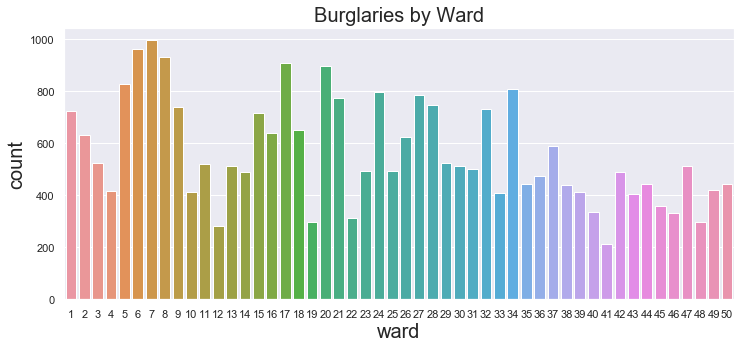

In [55]:
ax = sns.countplot(x="ward", data=burglary)
plt.title("Burglaries by Ward")
plt.show()

####  This is just a placeholder to associate these wards on the map, not the correct map yet. I am trying to make a similar map to show burglary statistics.  ![title](chicago_ward.jpg)

In [56]:
burglary_per_day = pd.DataFrame()
burglary_per_day =  burglary[['date', 'case_number']]
burglary_per_day = burglary_per_day.set_index(pd.to_datetime(burglary_per_day['date']))
burglary_per_day = burglary_per_day.resample('D').count()

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Number of Cases Reported')

Text(0.5, 1.0, 'Burglaries Reported')

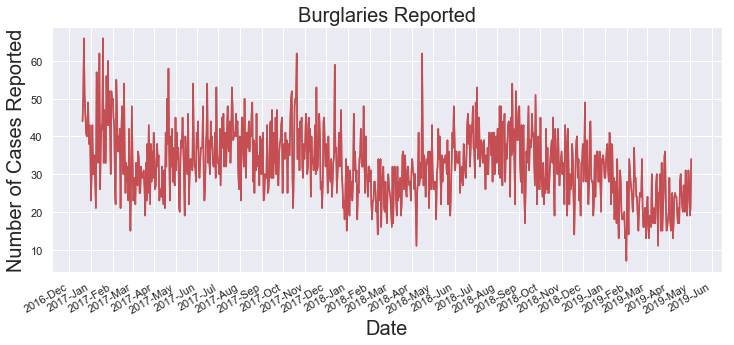

In [57]:
plt.rcParams['figure.figsize'] = 12,5
fig, ax = plt.subplots()
fig.autofmt_xdate()
#
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.DayLocator())
monthFmt = mdates.DateFormatter('%Y-%b')
ax.xaxis.set_major_formatter(monthFmt)

plt.plot(burglary_per_day.index, burglary_per_day, 'r-')
plt.xlabel('Date')
plt.ylabel('Number of Cases Reported')
plt.title('Burglaries Reported')
plt.show()

In [58]:
'''
import plotly.plotly as py
import plotly.figure_factory as ff
import numpy as np
import pandas as pd

aggs = ["count"]
agg = []
agg_func = []
for i in range(0, len(aggs)):
    agg = dict(
        args=['transforms[0].aggregations[0].func', aggs[i]],
        label=aggs[i],
        method='restyle'
    )
    agg_func.append(agg)


colorscale = [
    'rgb(193, 193, 193)',
    'rgb(239,239,239)',
    'rgb(195, 196, 222)',
    'rgb(144,148,194)',
    'rgb(101,104,168)',
    'rgb(65, 53, 132)'
]

fig = ff.create_choropleth(
    fips=fips, values=values, scope=['IL'],
    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,
    county_outline={'color': 'rgb(255,255,255)', 'width': 0.5}, round_legend_values=True,
    legend_title='Crimes by Ward', title='Chicago IL'
)
py.iplot(fig, filename='choropleth_crimes_by_ward_chicago')
'''

'\nimport plotly.plotly as py\nimport plotly.figure_factory as ff\nimport numpy as np\nimport pandas as pd\n\naggs = ["count"]\nagg = []\nagg_func = []\nfor i in range(0, len(aggs)):\n    agg = dict(\n        args=[\'transforms[0].aggregations[0].func\', aggs[i]],\n        label=aggs[i],\n        method=\'restyle\'\n    )\n    agg_func.append(agg)\n\n\ncolorscale = [\n    \'rgb(193, 193, 193)\',\n    \'rgb(239,239,239)\',\n    \'rgb(195, 196, 222)\',\n    \'rgb(144,148,194)\',\n    \'rgb(101,104,168)\',\n    \'rgb(65, 53, 132)\'\n]\n\nfig = ff.create_choropleth(\n    fips=fips, values=values, scope=[\'IL\'],\n    binning_endpoints=[14348, 63983, 134827, 426762, 2081313], colorscale=colorscale,\n    county_outline={\'color\': \'rgb(255,255,255)\', \'width\': 0.5}, round_legend_values=True,\n    legend_title=\'Crimes by Ward\', title=\'Chicago IL\'\n)\npy.iplot(fig, filename=\'choropleth_crimes_by_ward_chicago\')\n'

In [59]:
#burglary['date'] = burglary['date'].dt.date


## Business License
Data from business licenses. This will help us looking into licensing situation of the business whether there is tobaco/alcohol liscences or how that is related to the inspection failure. or may help answer if the businesses are more cleaner when they are close to duedate for license renewal?  

In [60]:
#business = pd.read_csv('../data/raw/Business_Licenses.csv', parse_dates=['LICENSE TERM START DATE'])
#business.head(2)
#business.info()
#date_window = pd.to_datetime('05/01/2016')
#business = business[business['LICENSE TERM START DATE'] > date_window]
#business.to_csv("../data/processed/business_license_termstart_gt_2016-05-01.csv")

In [61]:
date_cols =  ['APPLICATION CREATED DATE', 'LICENSE STATUS CHANGE DATE', 'PAYMENT DATE', 'LICENSE TERM START DATE','LICENSE TERM EXPIRATION DATE' , 'DATE ISSUED']
business = pd.read_csv('../data/processed/business_license_termstart_gt_2016-05-01.csv', parse_dates=date_cols)

Text(0.5, 1.0, 'Application Types')

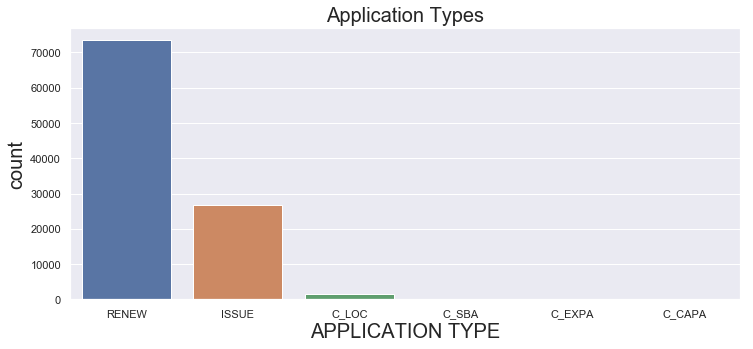

In [62]:
ax = sns.countplot(x="APPLICATION TYPE", data=business)
plt.title("Application Types")
plt.show()

APPLICATION TYPE: ‘ISSUE’ is the record associated with the initial license application. ‘RENEW’ is a subsequent renewal record. All renewal records are created with a term start date and term expiration date. ‘C_LOC’ is a change of location record. It means the business moved. ‘C_CAPA’ is a change of capacity record. Only a few license types may file this type of application. ‘C_EXPA’ only applies to businesses that have liquor licenses. It means the business location expanded.


LICENSE STATUS: ‘AAI’ means the license was issued. ‘AAC’ means the license was cancelled during its term.‘REV’means the license was revoked. ‘REA’means the license revocation has been appealed.

LICENSE STATUS CHANGE DATE: This date corresponds to the date a license was cancelled (AAC), revoked (REV) or appealed (REA).

In [63]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102062 entries, 0 to 102061
Data columns (total 35 columns):
Unnamed: 0                           102062 non-null int64
ID                                   102062 non-null object
LICENSE ID                           102062 non-null int64
ACCOUNT NUMBER                       102062 non-null int64
SITE NUMBER                          102062 non-null int64
LEGAL NAME                           102061 non-null object
DOING BUSINESS AS NAME               102011 non-null object
ADDRESS                              102062 non-null object
CITY                                 102060 non-null object
STATE                                102061 non-null object
ZIP CODE                             101899 non-null object
WARD                                 93601 non-null float64
PRECINCT                             83338 non-null float64
WARD PRECINCT                        93606 non-null object
POLICE DISTRICT                      83973 non-null fl

In [64]:
columns_to_take = ['LICENSE DESCRIPTION', 'ID', 'BUSINESS ACTIVITY ID', 'LICENSE CODE', 'LICENSE NUMBER', 'CONDITIONAL APPROVAL', 'APPLICATION TYPE', 'LICENSE TERM EXPIRATION DATE', 'LICENSE TERM START DATE', 'APPLICATION REQUIREMENTS COMPLETE','CONDITIONAL APPROVAL', 'BUSINESS ACTIVITY', 'DATE ISSUED', 'LICENSE STATUS CHANGE DATE' ]
business = business[columns_to_take]
column_dict = {}
for column in columns_to_take:
    column_dict[column] = column.lower().replace(' ', '_')
print(column_dict)
business.rename(columns= column_dict, inplace=True)
print(business['license_number'].nunique())
#food_business = pd.merge(left=food_data,right=business, left_on='license', right_on='LICENSE NUMBER')

{'LICENSE DESCRIPTION': 'license_description', 'ID': 'id', 'BUSINESS ACTIVITY ID': 'business_activity_id', 'LICENSE CODE': 'license_code', 'LICENSE NUMBER': 'license_number', 'CONDITIONAL APPROVAL': 'conditional_approval', 'APPLICATION TYPE': 'application_type', 'LICENSE TERM EXPIRATION DATE': 'license_term_expiration_date', 'LICENSE TERM START DATE': 'license_term_start_date', 'APPLICATION REQUIREMENTS COMPLETE': 'application_requirements_complete', 'BUSINESS ACTIVITY': 'business_activity', 'DATE ISSUED': 'date_issued', 'LICENSE STATUS CHANGE DATE': 'license_status_change_date'}
76909


In [65]:
business['license_number'] = business['license_number'].astype(int)
cond_approval = {"conditional_approval" : {"N" : 0, "Y" : 1}}
business.replace(cond_approval, inplace=True)

In [66]:
business = business.loc[:,~business.columns.duplicated()]
food_business = pd.merge(left=food_data,right=business, left_on='license', right_on='license_number')

In [67]:
food_business.license_code.value_counts()

1006    18276
1480       22
4404       22
1475        5
1470        1
8344        1
1329        1
Name: license_code, dtype: int64

In [68]:
food_business['HasAlcoholLicense'] = food_business['license_description'].str.lower().str.contains('alcohol')
food_business['HasTobaccoLicense'] = food_business['license_description'].str.lower().str.contains('tobacco')

Text(0.5, 1.0, 'Result')

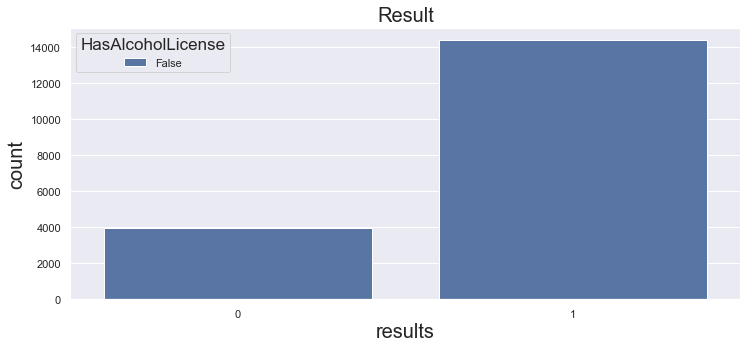

In [69]:
ax=sns.countplot(x='results', hue='HasAlcoholLicense', data=food_business)
plt.title("Result")
plt.show()

In [70]:
food_business.business_activity_id.value_counts()

775                      11435
735                       3971
781                       1822
782                        663
736                         45
781 | 735                   37
781 | 767                   31
767 | 735                   27
868                         22
767 | 781                   18
                         ...  
904 | 736 | 767 | 775        1
735 | 602                    1
829                          1
767 | 904 | 775              1
781 | 766 | 767              1
775 | 767 | 736              1
767 | 736                    1
735 | 775 | 904 | 767        1
781 | 602                    1
766 | 781 | 767              1
Name: business_activity_id, Length: 83, dtype: int64

In [71]:
food_business.columns

Index(['address', 'aka_name', 'dba_name', 'facility_type', 'inspection_date',
       'inspection_id', 'inspection_type', 'latitude', 'license', 'longitude',
       'results', 'risk', 'minor_violations', 'non_critical_violations',
       'critical_violations', 'facility_type_cat', 'risk_type_cat',
       'license_description', 'id', 'business_activity_id', 'license_code',
       'license_number', 'conditional_approval', 'application_type',
       'license_term_expiration_date', 'license_term_start_date',
       'application_requirements_complete', 'business_activity', 'date_issued',
       'license_status_change_date', 'HasAlcoholLicense', 'HasTobaccoLicense'],
      dtype='object')

Text(0.5, 1.0, 'Result')

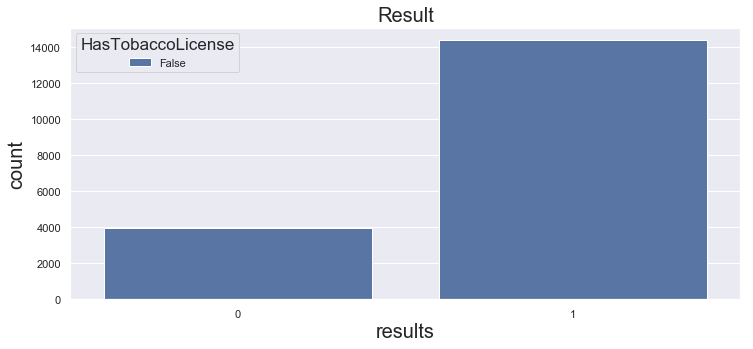

In [72]:
ax = sns.countplot(x='results', hue="HasTobaccoLicense", data=food_business)
plt.title("Result")
plt.show()

Now I want to merge the inspection and business data frames. we can do inner join on license number from inspection data and License ID from business data.

In [73]:
food_business.shape

(18328, 32)

In [74]:
#food_business['HasAlcoholLicense'].value_counts()
food_business['HasTobaccoLicense'].value_counts()

False    18328
Name: HasTobaccoLicense, dtype: int64

In [75]:
food_business['HasAlcoholLicense'].value_counts()

False    18328
Name: HasAlcoholLicense, dtype: int64

In [76]:
#food_data['facility_type'].value_counts()

## Garbage and Sanitation From (311 complaints)
Is there trash/garbage/sanitation/rodents etc complaints in the neighborhood or how that affects the outcome of the inspection. 

In [77]:
service_data = pd.read_json('../data/raw/servicedata.json', convert_dates=['close_date', 'created_date', 'last_modified_date'])
service_data.head(3)

,city,closed_date,community_area,created_date,created_day_of_week,created_hour,created_month,duplicate,electrical_district,electricity_grid,last_modified_date,latitude,legacy_record,legacy_sr_number,location,...,sanitation_division_days,sr_number,sr_short_code,sr_type,state,status,street_address,street_direction,street_name,street_number,street_type,ward,x_coordinate,y_coordinate,zip_code
0,None,None,NaN,2019-03-13 14:10:42,4,14,3,False,NaN,None,2019-03-13 18:30:17,NaN,False,None,None,...,None,SR19-01152326,CHECKFOR,Sewer Cleaning Inspection Request,None,Open,1510 S Lincoln ST,S,Lincoln,1510,ST,NaN,NaN,NaN,60064
1,None,2019-03-14T06:24:00.000,NaN,2019-03-05 17:03:18,3,17,3,False,NaN,None,2019-03-14 06:24:00,NaN,False,None,None,...,None,SR19-01111514,SIE,Garbage Cart Maintenance,None,Completed,S aVENUE c AVE,S,aVENUE c,None,AVE,NaN,NaN,NaN,None
10,None,2019-03-10T22:21:42.000,NaN,2019-03-10 13:43:11,1,13,3,False,NaN,None,2019-03-10 22:21:42,NaN,False,None,None,...,None,SR19-01134128,CHECKFOR,Sewer Cleaning Inspection Request,None,Completed,None,None,None,None,None,NaN,NaN,NaN,None


In [78]:
shape = service_data.shape
print(" So there are %d rows and %d columns in the data" % (shape[0], shape[1]))
#service_data['created_date'] = service_data['created_date'].dt.date

 So there are 97726 rows and 41 columns in the data


In [79]:
service_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97726 entries, 0 to 9999
Data columns (total 41 columns):
city                        62341 non-null object
closed_date                 92126 non-null object
community_area              97415 non-null float64
created_date                97726 non-null datetime64[ns]
created_day_of_week         97726 non-null int64
created_hour                97726 non-null int64
created_month               97726 non-null int64
duplicate                   97726 non-null bool
electrical_district         80404 non-null float64
electricity_grid            97378 non-null object
last_modified_date          97726 non-null datetime64[ns]
latitude                    97420 non-null float64
legacy_record               97726 non-null bool
legacy_sr_number            62257 non-null object
location                    97420 non-null object
location_address            97420 non-null object
location_city               97420 non-null object
location_state              97

I now want to count number of these incidents around the business and within some prespecified time. We can optimize the distance and the time windows but for the first pass study I am just foucsing on within 5 miles radii and the 7 days before the inspection date. 

In [80]:
service_data.isna().sum()

city                   35385
closed_date             5600
community_area           311
created_date               0
created_day_of_week        0
created_hour               0
created_month              0
duplicate                  0
electrical_district    17322
electricity_grid         348
                       ...  
status                     0
street_address            64
street_direction          72
street_name               69
street_number             73
street_type              727
ward                     310
x_coordinate             229
y_coordinate             229
zip_code                 888
Length: 41, dtype: int64

In [81]:
service_data['latitude'].fillna(service_data['latitude'].mode()[0], inplace=True)
service_data['longitude'].fillna(service_data['longitude'].mode()[0], inplace=True)

In [82]:
'''
# This is the function to calculate between two locations using (lat, long) info. 
# This is famout Haversine formula from geoscience. 
def get_distance_loop(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles 
    return c * r

def count_burglaries(longitude, latitude, date, df):
    mydf = df[(df['date'] - date) < pd.Timedelta(8, 'D')]
    matching_hits = 0
    for index, row in df.iterrows():
        distance = get_distance_loop(longitude, latitude, row['longitude'], row['latitude'])
        if distance < 0.5:
            matching_hits += 1
    return matching_hits

def count_sanitation_complaints(longitude, latitude, date, df):
    mydf = df[(df['created_date'] - date) < pd.Timedelta(8, 'D')]
    matching_hits = 0
    for index, row in df.iterrows():
        distance = get_distance_loop(longitude, latitude, row['longitude'], row['latitude'])
        if distance < 0.5:
            matching_hits += 1
    return matching_hits
'''

"\n# This is the function to calculate between two locations using (lat, long) info. \n# This is famout Haversine formula from geoscience. \ndef get_distance_loop(lon1, lat1, lon2, lat2):\n    lon1, lat1, lon2, lat2 = map(np.deg2rad, [lon1, lat1, lon2, lat2])\n    dlon = lon2 - lon1 \n    dlat = lat2 - lat1 \n    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2\n    c = 2 * np.arcsin(np.sqrt(a)) \n    r = 3956 # Radius of earth in miles \n    return c * r\n\ndef count_burglaries(longitude, latitude, date, df):\n    mydf = df[(df['date'] - date) < pd.Timedelta(8, 'D')]\n    matching_hits = 0\n    for index, row in df.iterrows():\n        distance = get_distance_loop(longitude, latitude, row['longitude'], row['latitude'])\n        if distance < 0.5:\n            matching_hits += 1\n    return matching_hits\n\ndef count_sanitation_complaints(longitude, latitude, date, df):\n    mydf = df[(df['created_date'] - date) < pd.Timedelta(8, 'D')]\n    matching_hits = 0\n   

In [119]:
# This is the function to calculate between two locations using (lat, long) info. 
# This is famout Haversine formula from geoscience. 
def get_distance(lon1, lat1, lonarray, latarray):
    lon1, lat1 = map(np.deg2rad, [lon1, lat1]) 
    lonarray = np.deg2rad(lonarray)
    latarray = np.deg2rad(latarray)
    dlon = lonarray - lon1 
    dlat = latarray - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(latarray) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 3956 # Radius of earth in miles 
    return c * r

#distance = np.vectorize(get_distance)

def count_burglaries(longitude, latitude, date, df):
    mydf = df[(df['date'] - date).dt.days < 8]
    if(mydf.empty):
        return 0
    #mydf['restaurant_long'] = longitude
    #mydf['restaurant_lat'] = latitude
    mydf['distance'] = get_distance(longitude, latitude, mydf['longitude'], mydf['latitude'])
    dfNew = mydf[(mydf['distance'] < 0.5)] # & (df['end_of_time_window'] < pd.Timedelta(8,'D'))]
    return dfNew.shape[0]

def count_sanitation_complaints(longitude, latitude, date, df):
    df = df[(df['duplicate'] !=1) & ((df['created_date'] -date).dt.days < 8 )]
    if df.empty:
        return 0
    df['restaurant_long'] = longitude
    df['restaurant_lat'] = latitude
    df['distance'] = get_distance(df['restaurant_long'], df['restaurant_lat'], df['longitude'], df['latitude'])
    dfNew = df[(df['distance'] < 0.5) ] # & (df['end_of_time_window'] < pd.Timedelta(8,'D')) & ]
    return dfNew.shape[0]

In [120]:
%timeit food_business['burglaries_this_week'] = food_business.apply(lambda x: count_burglaries(x['longitude'], x['latitude'], x['inspection_date'], burglary), axis=1)

51min 3s ± 12.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [122]:
%timeit food_business['service_complains_this_week'] = food_business.apply(lambda x: count_sanitation_complaints(x['longitude'], x['latitude'], x['inspection_date'], service_data), axis=1)

46min 27s ± 8.74 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [123]:
food_business.head()

,address,aka_name,dba_name,facility_type,inspection_date,inspection_id,inspection_type,latitude,license,longitude,results,risk,minor_violations,non_critical_violations,critical_violations,...,business_activity_id,license_code,license_number,conditional_approval,application_type,license_term_expiration_date,license_term_start_date,application_requirements_complete,business_activity,date_issued,license_status_change_date,HasAlcoholLicense,HasTobaccoLicense,burglaries_this_week,service_complains_this_week
0,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2017-01-03,1978836,Canvass,41.943325,2293828,-87.678514,1,Risk 1 (High),1,0,2,...,735,1006,2293828,0,RENEW,2019-05-15,2017-05-16,03/15/2017,Preparation of Food and Dining on Premise With...,2017-05-12,NaT,False,False,5,0
1,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2018-01-10,2135226,Canvass,41.943325,2293828,-87.678514,1,Risk 1 (High),0,1,3,...,735,1006,2293828,0,RENEW,2019-05-15,2017-05-16,03/15/2017,Preparation of Food and Dining on Premise With...,2017-05-12,NaT,False,False,65,0
2,2000 W ROSCOE ST,COMMONWEALTH TAVEN,"ROSCOE-DAMEN, CORP.",Restaurant,2019-05-07,2288359,Canvass,41.943325,2293828,-87.678514,1,Risk 1 (High),2,2,5,...,735,1006,2293828,0,RENEW,2019-05-15,2017-05-16,03/15/2017,Preparation of Food and Dining on Premise With...,2017-05-12,NaT,False,False,128,565
3,619 N WABASH AVE,PIZZERIA DUE,PIZZERIA DUE,Restaurant,2017-01-04,1978927,Canvass,41.893185,1331225,-87.626610,1,Risk 1 (High),0,0,2,...,775,1006,1331225,0,RENEW,2019-03-15,2017-03-16,01/15/2017,Retail Sales of Perishable Foods,2017-02-16,NaT,False,False,7,0
4,619 N WABASH AVE,PIZZERIA DUE,PIZZERIA DUE,Restaurant,2017-01-04,1978927,Canvass,41.893185,1331225,-87.626610,1,Risk 1 (High),0,0,2,...,775,1006,1331225,0,RENEW,2021-03-15,2019-03-16,01/15/2019,Retail Sales of Perishable Foods,2019-02-19,NaT,False,False,7,0


In [124]:
food_business.shape

(18328, 34)

In [125]:
food_business['license'].nunique()

6826

In [160]:
food_business.to_json('../data/processed/food_business_processed.json')

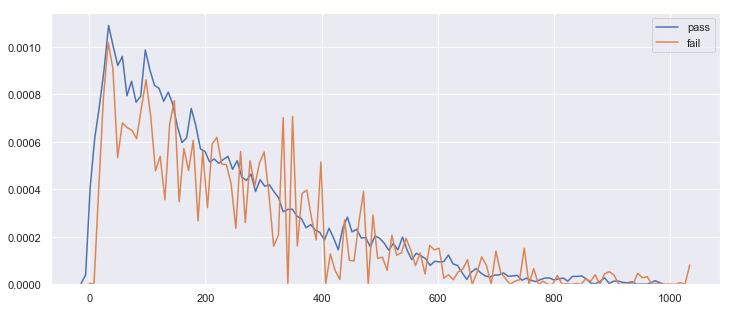

In [126]:
pass_ins = food_business[food_business['results'] == 1]
fail_ins = food_business[food_business['results'] == 0]
sns.kdeplot(pass_ins['service_complains_this_week'], label = 'pass')
sns.kdeplot(fail_ins['service_complains_this_week'], label = 'fail')
plt.show()

In [127]:
# write t_test function
def t_test(a, b, alpha, alternative='two-sided'):
    from scipy import stats
    import scipy.stats as ss
    import pandas as pd
    import statsmodels.stats.weightstats as ws
    
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)
# run the t-test at a 5% sig level
test = t_test(pass_ins['service_complains_this_week'], fail_ins['service_complains_this_week'], 0.05)
print(test)

DegFreedom    6314.551920
Difference       5.582607
Statistic        2.269289
PValue           0.023284
Low95CI          0.760036
High95CI        10.405178
dtype: float64


#### I also want to use Yelp's rating and comments ( for some sort of sentiment analysis if possible) in my model. So let's see if that is feasible. To start with, I am focusing only on the restaurants (category) that failed in the inspection. Also note taht yelp caps 5000 API calls per per day so I chose to focus on failed restaurants only. 
### Let's write some functions to use Yelp API. 

In [128]:
# yelp authorization ( Need to hide this ! )
#res_fail = fail_inspection[fail_inspection['facility_type_cat'] == 2]
import requests
api_key='skulWTrlVslLqkj5vY7u9fJErIOi-FB1prbAhB4ftwLLBSN5CarHecqiOPET6gVDOUhiEfvMD5O8tn--Evkbdn0MujX5Lncp5TNPNw_rzT_pAHtW0qIBC0pPgcqrXHYx' 
headers = {'Authorization': 'Bearer %s' % api_key,}

# find business match using business name (aka_name dba(doing business as name) 
def get_business_match(name, address, city="Chicago", state='IL', country='US'):
    params = {}
    params["name"] = name 
    params["address1"] = address
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        return data['businesses'][0]['id']
    except:
        return 0
    
    ## pull ratings and reviews of the matched businesses.

def get_reviews(business_id):
    query = "https://api.yelp.com/v3/businesses/%s/reviews" %business_id
    try:
        request = requests.get(query, headers=headers)
        data = request.json()
        return data
    except:
        ValueError("This business doesn't have any reviews")
        
def get_rating(business_id):
    try:
        query = "https://api.yelp.com/v3/businesses/%s" %business_id
        request = requests.get(query, headers=headers)
        data = request.json()
        return data["rating"]
    except:
        return 9999
    
def get_yelp_data(name, address, city="Chicago", state='IL', country='US'):
    params = {}
    params["name"] = name 
    params["address1"] = address
    params["city"] = 'Chicago'
    params["state"] = 'IL'
    params["country"] = 'US'
    yelp_data = []
    request = requests.get("https://api.yelp.com/v3/businesses/matches",headers=headers,params=params)
    #Transforms the JSON API response into a Python dictionary
    data = request.json()
    try:
        business_id = data['businesses'][0]['id']
        rating =  get_rating(business_id)
        reviews = get_reviews
        yelp_data = [busines_id, rating, reviews] 
        return yelp_data
    except:
        return 9999

In [129]:
#food_data['yelp_rating'] = food_data.apply(lambda x: get_rating(x["yelp_id"]), axis=1)
#food_data['yelp_id'] = food_data.apply(lambda x: get_business_match(x['aka_name'], x['address']), axis=1)
### Let's pull the information from the failed restaurants. 
#food_business['yelp_data'] = food_business.apply(lambda x: get_yelp_data(x['aka_name'], x['address']), axis=1)

That is encouraging! Looks like we can factor in those yelp ratings in our model. The mean rating has a peak at 4 even for failed restaurants but there is also a significant tail at the lower end of the spectrum. I may end of using it but I will have to set up a cronjob to make daily api calls for all these businesses.

In [130]:
features = ["risk_type_cat", "past_minor_violations", "past_non_critical_violations", "past_critical_violations", "facility_type_cat", "burglaries_this_week", "service_complains_this_week", 'HasTobaccoLicense', 'HasAlcoholLicense']
features

['risk_type_cat',
 'past_minor_violations',
 'past_non_critical_violations',
 'past_critical_violations',
 'facility_type_cat',
 'burglaries_this_week',
 'service_complains_this_week',
 'HasTobaccoLicense',
 'HasAlcoholLicense']

In [135]:
food_business['past_results'] = food_business.groupby('license')['results'].shift(-1).fillna(1)
food_business['past_critical_violations'] = food_business.groupby('license')['critical_violations'].shift(-1).fillna(0)
food_business['past_non_critical_violations'] = food_business.groupby('license')['non_critical_violations'].shift(-1).fillna(0)
food_business['past_minor_violations'] = food_business.groupby('license')['minor_violations'].shift(-1).fillna(0)

Now that we have some features we can start building some baseline models:

In [163]:
food_business_train = food_business[food_business['inspection_date'] < pd.to_datetime('2019-01-01')]
food_business_test  =  food_business[food_business['inspection_date'] > pd.to_datetime('2018-12-31')]

In [164]:
X_train = food_business_train[features]
Y_train = food_business_train['results']
X_test = food_business_test[features]
Y_test = food_business_test['results']

In [165]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(15677, 9)
(15677,)
(2651, 9)
(2651,)


Text(0.5, 1.0, 'Train Class Imbalance')

Text(0.5, 1.0, 'Test Class Imbalance')

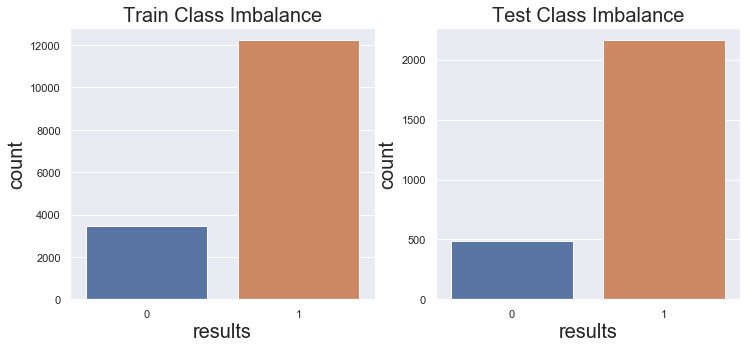

In [166]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Train Class Imbalance')
sns.countplot(x=Y_train, ax=ax1)

ax2.set_title('Test Class Imbalance')
sns.countplot(x=Y_test, ax=ax2)
plt.show()

We should note that there is class imbalance here and we should be careful about building our classfier. 

In [167]:
#Make sure that there are no n/a values in our data frame. 
print(X_train.isna().sum())
print(Y_train.isna().sum())

risk_type_cat                   0
past_minor_violations           0
past_non_critical_violations    0
past_critical_violations        0
facility_type_cat               0
burglaries_this_week            0
service_complains_this_week     0
HasTobaccoLicense               0
HasAlcoholLicense               0
dtype: int64
0


Text(0.5, 1.0, 'Before Scaling')

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype bool, int8, int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype bool, int8, int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning:

Data with input dtype bool, int8, int64, float64 were all converted to float64 by StandardScaler.

/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning:

Data with input dtype bool, int8, int64, float64 were all converted to float64 by StandardScaler.



Text(0.5, 1.0, 'After Standard Scaler')

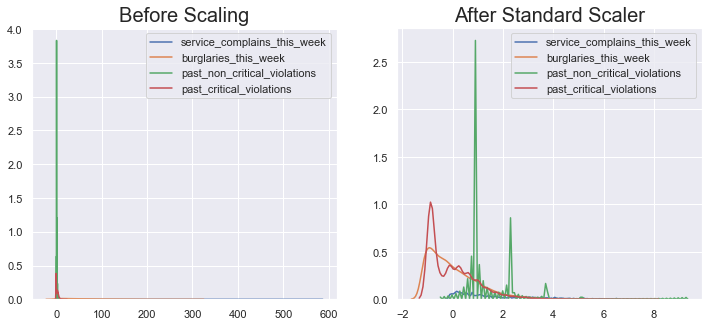

In [168]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['service_complains_this_week'], ax=ax1)
sns.kdeplot(X_train['burglaries_this_week'], ax=ax1)
sns.kdeplot(X_train['past_non_critical_violations'], ax=ax1)
sns.kdeplot(X_train['past_critical_violations'], ax=ax1)
train_columns = X_train.columns
test_columns = X_test.columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = pd.DataFrame(X_train, columns=train_columns)
X_test = pd.DataFrame(X_test, columns=test_columns)

ax2.set_title('After Standard Scaler')
sns.kdeplot(X_train['service_complains_this_week'], ax=ax2)
sns.kdeplot(X_train['burglaries_this_week'], ax=ax2)
sns.kdeplot(X_train['past_non_critical_violations'], ax=ax2)
sns.kdeplot(X_train['past_critical_violations'], ax=ax2)
plt.show()

### Baseline Models 

In [169]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

In [170]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
            

In [171]:
# Create dummy classifer
#dummy = DummyClassifier(strategy='stratified', random_state=0) 
# stratified strategy generates random predictions by respecting the training set class distribution.

# "Train" model
#dummy.fit(X_train, Y_train)

In [172]:
# Get accuracy score
#dummy.score(X_test, Y_test)  

In [173]:
# train a logistic regression model on the training set
# instantiate model
logreg = LogisticRegression(random_state=0, class_weight = 'balanced')

# fit model
logreg.fit(X_train, Y_train)

# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [174]:
print(logreg.coef_)

[[ 0.09695529  0.03672554 -0.5574543   0.08614887  0.          0.10362074
  -0.01048014  0.          0.        ]]


In [175]:
# calculate accuracy
print("Accuracy = %s " %metrics.accuracy_score(Y_test, y_pred_class))
print("Confusion Matrix ")
print(metrics.confusion_matrix(Y_test, y_pred_class))

Accuracy = 0.6857789513391173 
Confusion Matrix 
[[ 145  345]
 [ 488 1673]]


In [176]:
y_pred_proba = logreg.predict_proba(X_test)[:, 1]
print("ROC-AUC = %s " %metrics.roc_auc_score(Y_test, y_pred_proba))
print("F1-Score = %s " %metrics.f1_score(Y_test, y_pred_class))

ROC-AUC = 0.5588432226199133 
F1-Score = 0.8006700167504188 


<Figure size 576x576 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'ROC curve for Food Inspection Classifier')

Text(0.5, 0, 'False Positive Rate (1 - Specificity)')

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

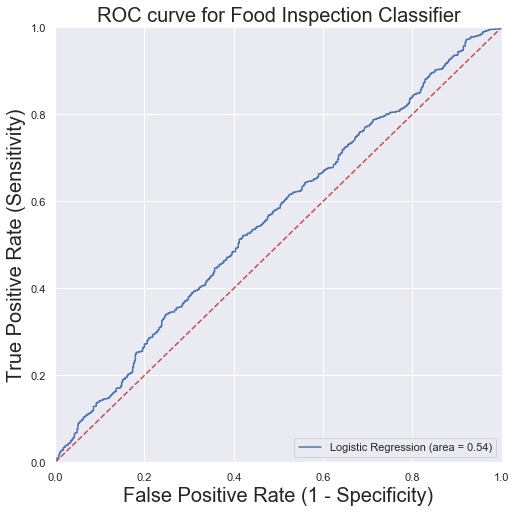

In [177]:
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, y_pred_proba)
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % metrics.roc_auc_score(Y_test, y_pred_class))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Food Inspection Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [185]:
dt = DecisionTreeClassifier(max_depth = 4)
print(dt)
dt = dt.fit(X_train, Y_train)
dt_y_pred_test = dt.predict(X_test)
dt_y_pred_test_proba = dt.predict_proba(X_test)[:, 1]
print("Accuracy = %s " % metrics.accuracy_score(Y_test, dt_y_pred_test))
print("F1 Score = %s " %metrics.f1_score(Y_test, dt_y_pred_test))
print("ROC-AUC Score = %s "%metrics.roc_auc_score(Y_test, dt_y_pred_test_proba))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
Accuracy = 0.8091286307053942 
F1 Score = 0.8940979489326079 
ROC-AUC Score = 0.5806146058608542 


<Figure size 576x576 with 0 Axes>

(0.0, 1.0)

(0.0, 1.0)

Text(0.5, 1.0, 'ROC curve for Decision Tree')

Text(0.5, 0, 'False Positive Rate (1 - Specificity)')

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

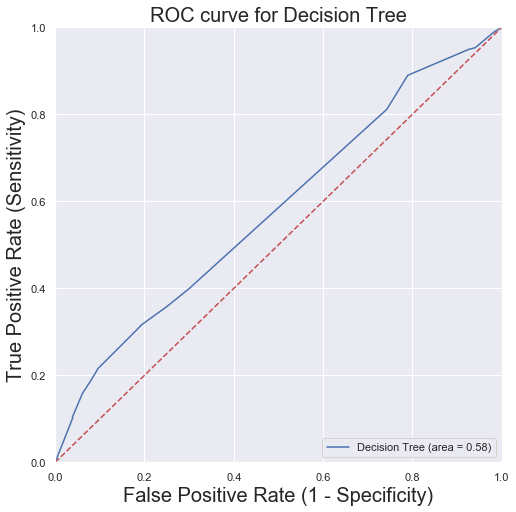

In [186]:
plt.figure(figsize=(8,8))
fpr, tpr, thresholds = metrics.roc_curve(Y_test, dt_y_pred_test_proba)
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % metrics.roc_auc_score(Y_test, dt_y_pred_test_proba))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Decision Tree')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Random Forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=3, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=13, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=17, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=19, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=21, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=23, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=27, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=29, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=31, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=33, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=35, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=37, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=39, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=41, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=43, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=45, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=47, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=49, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=51, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=53, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=55, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=57, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=59, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=61, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=63, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=65, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=67, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=69, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=71, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=73, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=77, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=79, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=81, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=83, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=85, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=87, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=91, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=93, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=95, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=97, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=99, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Text(0, 0.5, 'AUC score')

Text(0.5, 0, 'n_estimators')

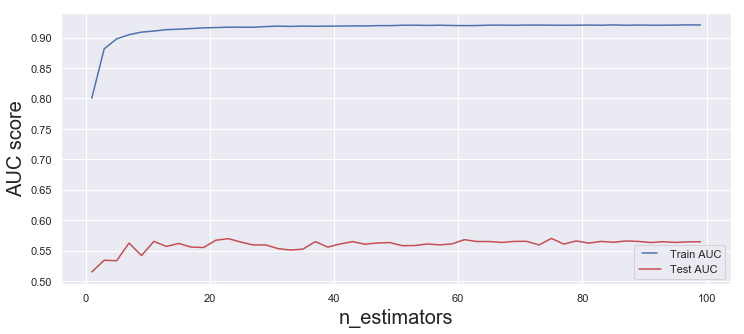

In [187]:
n_estimators = np.arange(1, 100, 2)
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, Y_train)
   train_pred_proba = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, train_pred_proba)
   roc_auc = metrics.roc_auc_score(Y_train, train_pred_proba)
   train_results.append(roc_auc)
   y_pred_proba = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, y_pred_proba)
   roc_auc = metrics.roc_auc_score(Y_test, y_pred_proba)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label= 'Train AUC')
line2, = plt.plot(n_estimators, test_results, 'r', label= 'Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

In [188]:
clf = RandomForestClassifier(n_estimators = 7)
clf = clf.fit(X_train, Y_train)
y_pred_rf = clf.predict(X_test)
# calculate accuracy
print("Accuracy = %s " %metrics.accuracy_score(Y_test, y_pred_rf))
print("F1-Score = %s " %metrics.f1_score(Y_test, y_pred_rf))
print("Confusion Matrix")
print(metrics.confusion_matrix(Y_test, y_pred_rf))

Accuracy = 0.7506601282534893 
F1-Score = 0.8523564887201253 
Confusion Matrix
[[  82  408]
 [ 253 1908]]


Text(0.5, 0, 'Feature Importance Score')

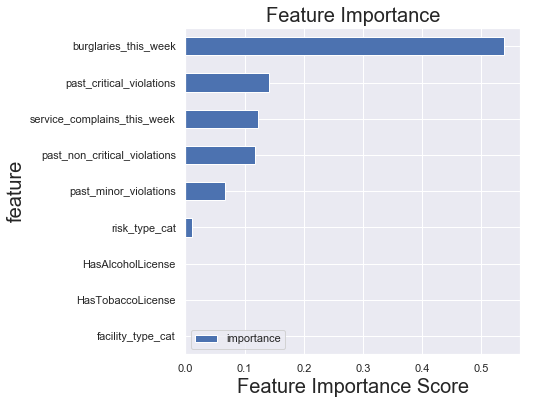

In [182]:
feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
feat_imp['feature'] = X_train.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[:12]
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title="Feature Importance", figsize=(6, 6))
plt.xlabel('Feature Importance Score')
plt.show()